# Robust Versions

In [1]:
import numpy as np

def mdpgen(S, A):
    """
    Generate a random MDP with S states and A actions.

    Returns:
        P    (S, S, A) array  : transition kernels P(s' | s, a)
        R    (S, A)     array : rewards R(s, a) in [0, 10)
        Ppi  (S, S)     array : transition matrix under uniform policy
        p    (S,)       array : stationary distribution of Ppi
    """
    # 1) Random transition kernels, then normalize rows
    P = np.random.rand(S, S, A)
    for j in range(A):
        for i in range(S):
            P[i, :, j] /= P[i, :, j].sum()

    # 2) Uniform behavior policy transition matrix
    Ppi = P.sum(axis=2) / A

    # 3) Stationary distribution: left eigenvector of Ppi for eigenvalue 1
    #    which is the right eigenvector of Ppi.T
    eigvals, eigvecs = np.linalg.eig(Ppi.T)
    idx = np.argmin(np.abs(eigvals - 1.0))
    p = np.real(eigvecs[:, idx])
    # enforce non-negativity up to a sign
    p *= np.sign(p)
    p /= p.sum()

    # 4) Random reward function
    R = np.random.rand(S, A)

    return P, R, Ppi, p


In [2]:
S, A, gamma, T = 10, 5, 0.5, 25000
P, R, Ppi, p = mdpgen(S, A)
def value_iteration(P, R, gamma, T):
    """
    Run value iteration for T steps to compute optimal Q-function.
    Returns:
        Q     (S, A)   array : estimated state-action values
        Err   (T,)     array : infinity-norm Bellman residual at each iteration
    """
    S, _, A = P.shape
    Q = np.zeros((S, A))
    Err = np.zeros(T)
    for t in range(T):
        Q_old = Q.copy()
        V = Q_old.max(axis=1)  # state-value function
        # Bellman optimality update vectorized
        Q = R + gamma * np.tensordot(P, V, axes=([1], [0]))
        Err[t] = np.max(np.abs(Q - Q_old))
    return Q, Err



In [3]:
# Generate MDP and optimal Q-values
#P, R = mdpgen(S, A)
Qopt,_ = value_iteration(P, R, gamma, T=25000)
#Qopt = np.array(Qopt)

In [4]:
np.savez('Qlearn_robust_fed_q_data_new.npz',
         P=P,
         R=R,
         p=p,
         Qopt=Qopt,
         gamma=gamma,
         S=np.int32(S),
         A=np.int32(A))

In [5]:
import numpy as np

def median_of_means(X, P_groups):
    X = np.asarray(X, dtype=float)
    n = len(X)
    P = max(1, min(int(P_groups), n))
    if P == 1:
        return float(X.mean())
    idx = np.random.permutation(n)
    blocks = np.array_split(X[idx], P)
    means = np.array([b.mean() for b in blocks if b.size > 0], dtype=float)
    return float(np.median(means))


In [6]:
def choose_mom_params(S, A, T, M, epsilon, delta):
    bar_delta = max(delta / (S * A * T), 1e-12)
    raw_P = int(np.ceil(8 * epsilon * M + (256.0 / 7.0) * np.log(2.0 / bar_delta)))
    return max(1, min(raw_P, M))  # 1 ≤ P ≤ M

def empirical_transition_estimates(samples, S, A, H):
    counts = np.zeros((S, S, A))
    for s, a, s_next in samples:
        counts[s_next, s, a] += 1
    # Add a small value to prevent division by zero if a state-action pair was not visited
    P_hat = counts / (np.sum(counts, axis=0) + 1e-9)
    return P_hat

def agent_epoch_update(Q, R, P_hat, gamma):
    S, _, A = P_hat.shape
    d = np.zeros((S, A))
    V = Q.max(axis=1)
    for s in range(S):
        for a in range(A):
            # P_hat is (S, S, A), we need P_hat[:, s, a] which is (S,)
            d[s, a] = R[s, a] + gamma * np.dot(P_hat[:, s, a], V)
    return d

def choose_K(M, T, gamma, c1=10):
    return int(np.ceil(c1 * np.log(M * T) / (1 - gamma)))

def compute_alpha(M, T, gamma, K):
    return np.log(M * T) / ((1 - gamma) * K)

In [7]:
import numpy as np

def _normalize_kernel(P):
    """
    Ensure P has shape (S, S, A) with each column P[:, s, a] a valid prob. vector.
    - clips negatives to 0
    - replaces NaNs/±inf with 0
    - if a column sums to 0, sets it to uniform
    - renormalizes columns to sum to 1
    """
    P = np.array(P, dtype=float, copy=True)
    P = np.nan_to_num(P, nan=0.0, posinf=0.0, neginf=0.0)
    P[P < 0] = 0.0

    # sum over next-state axis
    sums = P.sum(axis=0, keepdims=True)  # shape (1, S, A)
    # columns with zero sum -> uniform
    zero_mask = (sums <= 0.0)
    if np.any(zero_mask):
        P[:, zero_mask.squeeze(), :] = 1.0 / P.shape[0]
        sums = P.sum(axis=0, keepdims=True)  # recompute

    P /= sums
    return P

def robust_fed_q(
    S, A, M, T, gamma, delta, P_env, R_env, alpha, K,
    *,
    malicious_fraction=None,
    num_malicious=None,
    malicious_idx=None,
    seed=0,
    adversary_bias=-10000.0,
    use_mom=True
):
    # ---- sanitize TRUE env kernel once ----
    P_env = _normalize_kernel(P_env)

    # deterministic malicious set (same as before)
    if malicious_idx is None:
        if num_malicious is None:
            if malicious_fraction is None:
                malicious_fraction = 0.0
            num_malicious = int(round(malicious_fraction * M))
        num_malicious = int(np.clip(num_malicious, 0, M))
        rng = np.random.default_rng(seed)
        malicious_idx = np.array(sorted(rng.choice(M, size=num_malicious, replace=False)))
    else:
        malicious_idx = np.array(sorted(set(malicious_idx)))
        malicious_idx = malicious_idx[(malicious_idx >= 0) & (malicious_idx < M)]

    H = max(1, T // K)
    Q = np.zeros((S, A))
    residual_trace = []

    P_blocks = choose_mom_params(S, A, T, M, epsilon, delta)

    for k in range(K):
        directions = np.zeros((M, S, A))

        for i in range(M):
            samples = []
            for s in range(S):
                for a in range(A):
                    # ---- guard just before sampling ----
                    p_dist = P_env[:, s, a].astype(float)
                    # eliminate roundoff/strays and renormalize
                    p_dist = np.nan_to_num(p_dist, nan=0.0, posinf=0.0, neginf=0.0)
                    p_dist[p_dist < 0] = 0.0
                    total = p_dist.sum()
                    if not np.isfinite(total) or total <= 0:
                        p_dist = np.ones(S) / S
                    else:
                        p_dist /= total

                    for _ in range(H):
                        s_next = np.random.choice(S, p=p_dist)
                        samples.append((s, a, s_next))

            P_hat = empirical_transition_estimates(samples, S, A, H)
            d = agent_epoch_update(Q, R_env, P_hat, gamma)

            if i in malicious_idx:
                d = d + adversary_bias

            directions[i] = d

        # aggregate
        for s in range(S):
            for a in range(A):
                if use_mom:
                    agg = median_of_means(directions[:, s, a], P_blocks)
                else:
                    agg = np.mean(directions[:, s, a])
                Q[s, a] = (1 - alpha) * Q[s, a] + alpha * agg

        # Bellman residual under TRUE (already normalized) env
        V = Q.max(axis=1)
        TQ_true = np.zeros_like(Q)
        for s in range(S):
            for a in range(A):
                TQ_true[s, a] = R_env[s, a] + gamma * np.dot(P_env[:, s, a], V)
        residual_trace.append(np.max(np.abs(TQ_true - Q)))

    return Q, np.array(residual_trace), malicious_idx


In [43]:
import matplotlib.pyplot as plt

epsilon = 0.1
delta = 0.05
agent_list = [500]

traces = {}
malicious_sets = {}  # optional: keep track of which agents were malicious

for M in agent_list:
    K = choose_K(M, T, gamma)
    alpha = compute_alpha(M, T, gamma, K)

    # Example: fix 20% of agents as malicious deterministically
    # (remove these kwargs if you want the defaults from your function)
    Q_final, res_trace, bad_idx = robust_fed_q(
        S, A, M, T, gamma, delta, P, R, alpha, K,
        malicious_fraction=0.1,    # or: num_malicious=...
        seed=42,                   # deterministic selection
        use_mom=True               # MoM aggregation (toggle as you like)
    )
    traces[M] = res_trace
    malicious_sets[M] = bad_idx

np.save("robust_fedq_traces_500_frac_0.1.npy", traces)


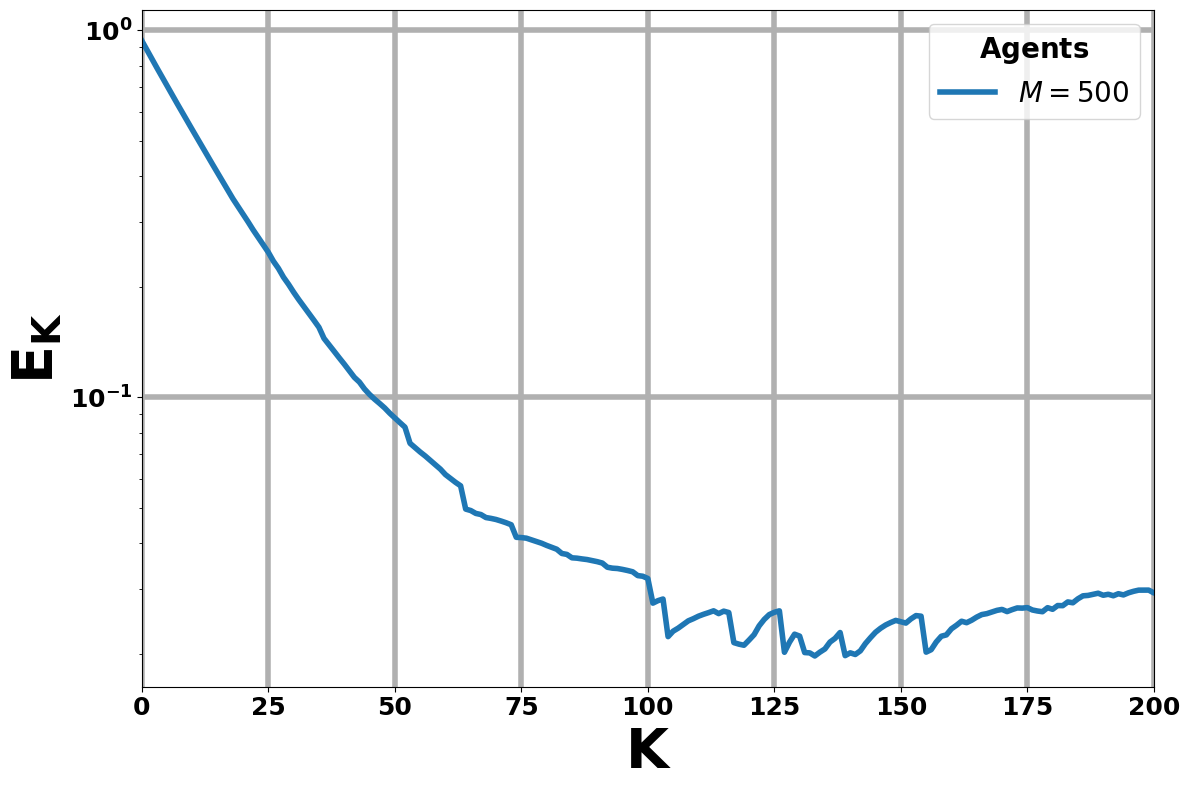

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Load (works even if the .npy contains a dict) ----
obj = np.load('robust_fedq_traces_500_frac_0.1.npy', allow_pickle=True)

# If you saved a dict like: traces = {1: arr1, 100: arr2}
# then `obj` is either that dict or a 0-d array containing it.
if isinstance(obj, np.ndarray) and obj.dtype == object and obj.shape == ():
    traces = obj.item()
elif isinstance(obj, dict):
    traces = obj
else:
    # If it’s already a numeric 2D array, just use it directly
    r_error_matrix = obj
    traces = None

# Build a matrix in the order of M, padding with the last value (edge padding)
M = [500]
if traces is not None:
    curves = [np.asarray(traces[m]).ravel() for m in M]
    max_T = max(len(c) for c in curves)
    # Edge-pad to the same length
    padded = []
    for c in curves:
        if len(c) < max_T:
            pad = np.full(max_T - len(c), c[-1])
            c = np.concatenate([c, pad])
        padded.append(c)
    r_error_matrix = np.vstack(padded)

# ---- Plot ----
n_curves, T = r_error_matrix.shape
plt.figure(figsize=(12, 8))
for idx, m in enumerate(M):
    plt.semilogy(r_error_matrix[idx], label=fr'$M={m}$', linewidth=4)

plt.xlim([0, 200])
plt.xlabel(r'$\mathbf{K}$', fontsize=40, fontweight='bold')
plt.ylabel(r'$\mathbf{E_K}$', fontsize=40, fontweight='bold')
plt.legend(title=r'$\mathbf{Agents}$', fontsize=20, title_fontsize=20)
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.grid(True, linewidth=4)
plt.tight_layout()

# Save BEFORE show (and include an extension)
plt.savefig("robust_fedq_traces_500_frac_0.1.png", dpi=1200, bbox_inches="tight")
plt.show()


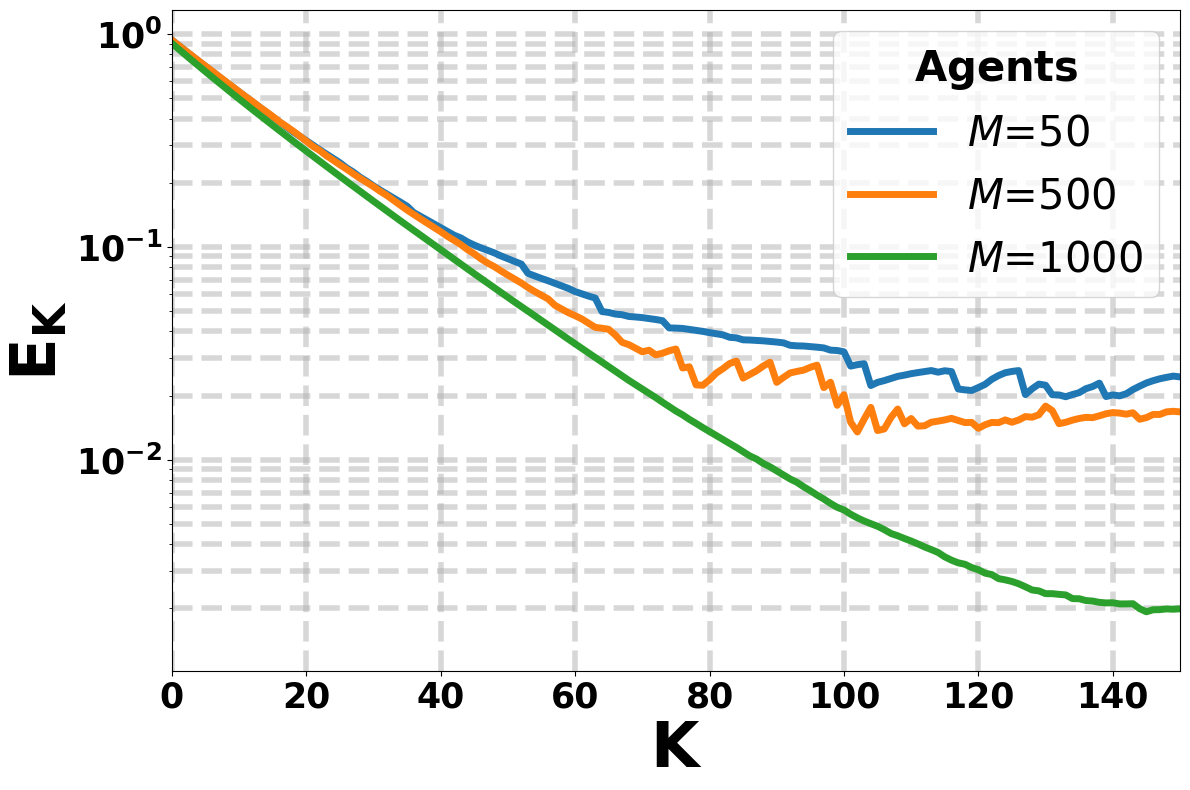

Saved: combined_traces.npy and combined_plot.png


In [52]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Mapping, Sequence

# --- configure your file paths here ---
paths = [
    "robust_fedq_traces_50_frac_0.1.npy",
    "robust_fedq_traces_500_frac_0.1.npy",
    "robust_fedq_traces_1000_frac_0.1.npy",
]

# Optional: keep only certain M values if you want (e.g., {10, 100}).
# Leave as None to keep everything.
KEEP_M = None  # e.g., set to {10, 100}

# ---------- helpers ----------
def to_float_1d(x):
    """Return a 1D float ndarray or raise."""
    arr = np.asarray(x)
    if arr.ndim != 1:
        raise ValueError("not 1D")
    return arr.astype(float)

def parse_Ms_from_filename(name):

    base = os.path.basename(name)
    m = re.search(r'traces_(.*?)_frac', base)
    if not m:
        return []
    chunk = m.group(1)
    Ms = []
    for part in chunk.split('_'):
        if part.isdigit():
            Ms.append(int(part))
        else:
            # handle things like 'M10' if present (not expected here)
            digits = re.findall(r'\d+', part)
            for d in digits:
                Ms.append(int(d))
    return Ms

def normalize_obj_to_curves_and_labels(obj, base_label=None):
    """
    Convert whatever was stored (ndarray, list, dict, ragged object, etc.)
    into (list_of_1d_float_arrays, list_of_labels).
    """
    curves, labels = [], []

    if isinstance(obj, np.ndarray):
        if obj.dtype == object:
            # Could be 0-D object array or 1-D container of arrays
            if obj.ndim == 0:
                return normalize_obj_to_curves_and_labels(obj.item(), base_label)
            elif obj.ndim == 1:
                # try each element
                for i, el in enumerate(obj):
                    try:
                        curves.append(to_float_1d(el))
                        labels.append(f"{base_label or 'row'}[{i}]")
                    except Exception:
                        # recurse if element is a nested container
                        subc, subl = normalize_obj_to_curves_and_labels(el, f"{base_label or 'row'}[{i}]")
                        curves.extend(subc); labels.extend(subl)
            else:
                # Unexpected higher-dim object; flatten and try recursively
                flat = obj.ravel()
                for i, el in enumerate(flat):
                    subc, subl = normalize_obj_to_curves_and_labels(el, f"{base_label or 'row'}[{i}]")
                    curves.extend(subc); labels.extend(subl)
        else:
            # Numeric ndarray
            if obj.ndim == 1:
                curves.append(obj.astype(float))
                labels.append(base_label or "curve")
            elif obj.ndim == 2:
                for i in range(obj.shape[0]):
                    curves.append(obj[i].astype(float))
                    labels.append(f"{base_label or 'row'}[{i}]")
            else:
                # flatten along first axis
                first = obj.reshape(obj.shape[0], -1)
                for i in range(first.shape[0]):
                    curves.append(first[i].astype(float))
                    labels.append(f"{base_label or 'row'}[{i}]")
    elif isinstance(obj, Mapping):
        # Dict-like: keys -> labels, values -> arrays or nested
        for k, v in obj.items():
            subc, subl = normalize_obj_to_curves_and_labels(v, str(k))
            curves.extend(subc); labels.extend(subl)
    elif isinstance(obj, (list, tuple)) and not isinstance(obj, (str, bytes)):
        for i, v in enumerate(obj):
            try:
                curves.append(to_float_1d(v))
                labels.append(f"{base_label or 'row'}[{i}]")
            except Exception:
                subc, subl = normalize_obj_to_curves_and_labels(v, f"{base_label or 'row'}[{i}]")
                curves.extend(subc); labels.extend(subl)
    else:
        # Last resort: try converting directly
        try:
            curves.append(to_float_1d(obj))
            labels.append(base_label or "curve")
        except Exception:
            pass

    return curves, labels

def load_curves_any(path):
    """
    Load a .npy that may contain numeric arrays, object arrays,
    lists/tuples of arrays, or dicts. Returns (curves, labels).
    """
    # Try safe path first
    try:
        arr = np.load(path, allow_pickle=False)
        curves, labels = normalize_obj_to_curves_and_labels(arr, os.path.splitext(os.path.basename(path))[0])
        if curves:
            return curves, labels
    except Exception:
        pass

    # Fallback to pickled content
    arr = np.load(path, allow_pickle=True)
    # If 0-D object array, unwrap
    if isinstance(arr, np.ndarray) and arr.dtype == object and arr.ndim == 0:
        arr = arr.item()

    curves, labels = normalize_obj_to_curves_and_labels(arr, os.path.splitext(os.path.basename(path))[0])
    if not curves:
        raise ValueError(f"No numeric 1D curves found in {path}")
    return curves, labels

def pad_edge(x, L):
    if len(x) == L: return x
    out = np.empty(L, dtype=float)
    if len(x) == 0:
        out[:] = np.nan
    else:
        out[:len(x)] = x
        out[len(x):] = x[-1]
    return out

# ---------- load, label, (optionally) filter ----------
all_curves, all_labels = [], []
for p in paths:
    curves, labels = load_curves_any(p)

    # --- FORCE legend labels to "M=..." when possible ---
    Ms = parse_Ms_from_filename(p)
    if len(Ms) == len(curves) and len(curves) > 0:
        labels = [f"$M$={m}" for m in Ms]
    else:
        # keep existing labels as fallback
        pass

    all_curves.extend(curves)
    all_labels.extend(labels)

# Optional filter by M values if KEEP_M is set and labels like "M=10" exist
if KEEP_M is not None:
    sel_curves, sel_labels = [], []
    for y, lab in zip(all_curves, all_labels):
        m_match = re.search(r"M=(\d+)", lab)
        if m_match and int(m_match.group(1)) in KEEP_M:
            sel_curves.append(y); sel_labels.append(lab)
    if sel_curves:
        all_curves, all_labels = sel_curves, sel_labels

# ---------- combine (pad) ----------
if not all_curves:
    raise RuntimeError("No curves collected. Check file contents/paths.")

max_len = max(len(c) for c in all_curves)
combined = np.vstack([pad_edge(c, max_len) for c in all_curves])
np.save("combined_traces.npy", combined)  # clean, non-pickled float array

# ---------- plot ----------
x = np.arange(max_len)
plt.figure(figsize=(12, 8))
for i, y in enumerate(combined):
    label = all_labels[i] if i < len(all_labels) else f"M? curve {i+1}"
    # semilogy if positive
    if np.all(y > 0):
        plt.semilogy(x, y, linewidth=5, label=label)
    else:
        plt.plot(x, y, linewidth=5, label=label)

plt.xlim([0, 150])
plt.xlabel(r'$\mathbf{K}$', fontsize=45, fontweight='bold')
plt.ylabel(r'$\mathbf{E_K}$', fontsize=45, fontweight='bold')
plt.legend(title=r'$\mathbf{Agents}$', fontsize=30, title_fontsize=30)
plt.xticks(fontsize=25, fontweight='bold')
plt.yticks(fontsize=25, fontweight='bold')
plt.grid(True, which="both", linestyle="--", alpha=0.5, linewidth=4)
plt.tight_layout()
plt.savefig("combined_plot.png", dpi=1200)
plt.show()

print("Saved: combined_traces.npy and combined_plot.png")


# Vanilla Versions




In [ ]:
import matplotlib.pyplot as plt


delta = 0.05
agent_list = [1000]

traces = {}
malicious_sets = {}  # optional: keep track of which agents were malicious

for M in agent_list:
    K = choose_K(M, T, gamma)
    alpha = compute_alpha(M, T, gamma, K)

    # Example: fix 20% of agents as malicious deterministically
    # (remove these kwargs if you want the defaults from your function)
    Q_final, res_trace, bad_idx = robust_fed_q(
        S, A, M, T, gamma, delta, P, R, alpha, K,
        malicious_fraction=0.05,    # or: num_malicious=...
        seed=42,                   # deterministic selection
        use_mom=False               # MoM aggregation (toggle as you like)
    )
    traces[M] = res_trace
    malicious_sets[M] = bad_idx

np.save("vanilla_traces_1000_frac_0.05_vanilla.npy", traces)


In [ ]:
import matplotlib.pyplot as plt


delta = 0.05
agent_list = [1000]

traces = {}
malicious_sets = {}  # optional: keep track of which agents were malicious

for M in agent_list:
    K = choose_K(M, T, gamma)
    alpha = compute_alpha(M, T, gamma, K)

    # Example: fix 20% of agents as malicious deterministically
    # (remove these kwargs if you want the defaults from your function)
    Q_final, res_trace, bad_idx = robust_fed_q(
        S, A, M, T, gamma, delta, P, R, alpha, K,
        malicious_fraction=0.01,    # or: num_malicious=...
        seed=42,                   # deterministic selection
        use_mom=False               # MoM aggregation (toggle as you like)
    )
    traces[M] = res_trace
    malicious_sets[M] = bad_idx

np.save("vanilla_traces_1000_frac_0.01_vanilla.npy", traces)


In [ ]:
import matplotlib.pyplot as plt


delta = 0.05
agent_list = [1000]

traces = {}
malicious_sets = {}  # optional: keep track of which agents were malicious

for M in agent_list:
    K = choose_K(M, T, gamma)
    alpha = compute_alpha(M, T, gamma, K)

    # Example: fix 20% of agents as malicious deterministically
    # (remove these kwargs if you want the defaults from your function)
    Q_final, res_trace, bad_idx = robust_fed_q(
        S, A, M, T, gamma, delta, P, R, alpha, K,
        malicious_fraction=0.1,    # or: num_malicious=...
        seed=42,                   # deterministic selection
        use_mom=False               # MoM aggregation (toggle as you like)
    )
    traces[M] = res_trace
    malicious_sets[M] = bad_idx

np.save("vanilla_traces_1000_frac_0.1_vanilla.npy", traces)


In [ ]:
import matplotlib.pyplot as plt


delta = 0.05
agent_list = [500]

traces = {}
malicious_sets = {}  # optional: keep track of which agents were malicious

for M in agent_list:
    K = choose_K(M, T, gamma)
    alpha = compute_alpha(M, T, gamma, K)

    # Example: fix 20% of agents as malicious deterministically
    # (remove these kwargs if you want the defaults from your function)
    Q_final, res_trace, bad_idx = robust_fed_q(
        S, A, M, T, gamma, delta, P, R, alpha, K,
        malicious_fraction=0.1,    # or: num_malicious=...
        seed=42,                   # deterministic selection
        use_mom=False               # MoM aggregation (toggle as you like)
    )
    traces[M] = res_trace
    malicious_sets[M] = bad_idx

np.save("vanilla_traces_500_frac_0.1_vanilla.npy", traces)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Load (works even if the .npy contains a dict) ----
obj = np.load('vanilla_traces_500_frac_0.1_vanilla.npy', allow_pickle=True)

# If you saved a dict like: traces = {1: arr1, 100: arr2}
# then `obj` is either that dict or a 0-d array containing it.
if isinstance(obj, np.ndarray) and obj.dtype == object and obj.shape == ():
    traces = obj.item()
elif isinstance(obj, dict):
    traces = obj
else:
    # If it’s already a numeric 2D array, just use it directly
    r_error_matrix = obj
    traces = None

# Build a matrix in the order of M, padding with the last value (edge padding)
M = [500]
if traces is not None:
    curves = [np.asarray(traces[m]).ravel() for m in M]
    max_T = max(len(c) for c in curves)
    # Edge-pad to the same length
    padded = []
    for c in curves:
        if len(c) < max_T:
            pad = np.full(max_T - len(c), c[-1])
            c = np.concatenate([c, pad])
        padded.append(c)
    r_error_matrix = np.vstack(padded)

# ---- Plot ----
n_curves, T = r_error_matrix.shape
plt.figure(figsize=(12, 8))
for idx, m in enumerate(M):
    plt.semilogy(r_error_matrix[idx], label=fr'$M={m}$', linewidth=4)

plt.xlim([0, 200])
plt.xlabel(r'$\mathbf{K}$', fontsize=40, fontweight='bold')
plt.ylabel(r'$\mathbf{E_K}$', fontsize=40, fontweight='bold')
plt.legend(title=r'$\mathbf{Agents}$', fontsize=20, title_fontsize=20)
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.grid(True, linewidth=4)
plt.tight_layout()

# Save BEFORE show (and include an extension)
plt.savefig("robust_fedq_traces_500_frac_0.1.png", dpi=1200, bbox_inches="tight")
plt.show()


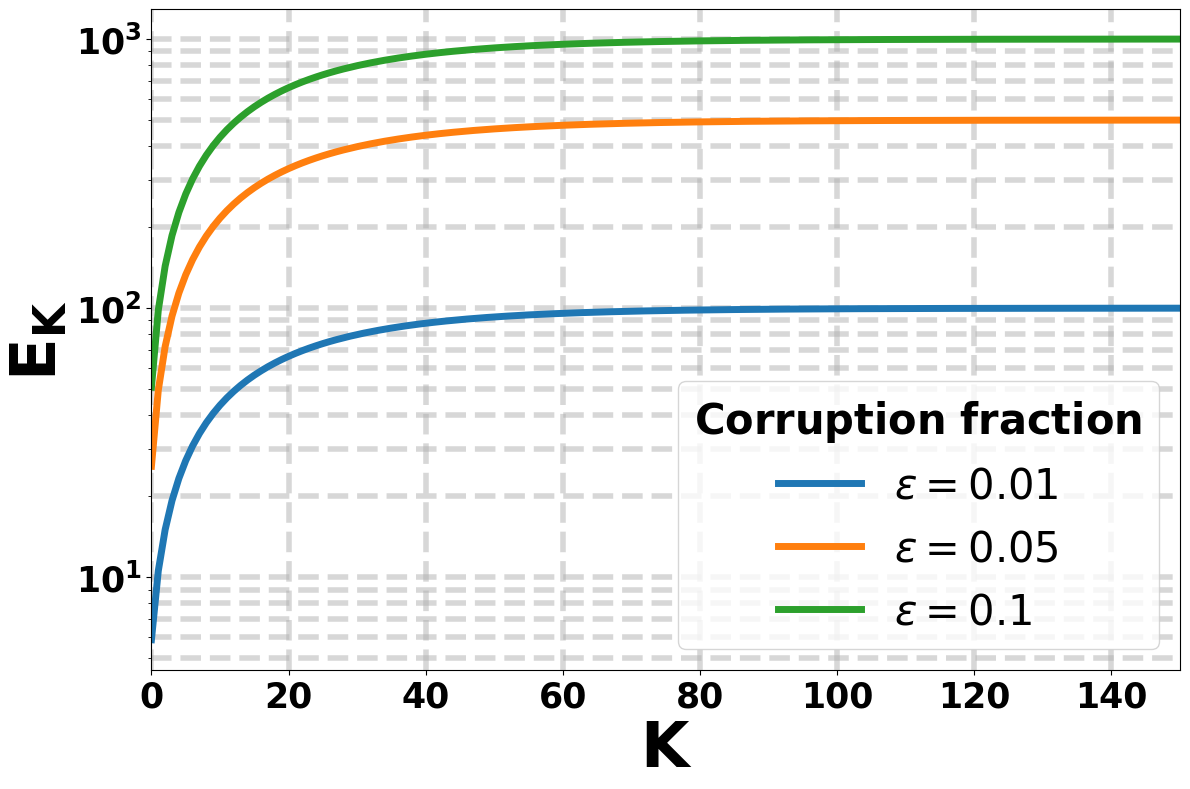

Saved: combined_traces.npy and combined_plot.png


In [53]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Mapping, Sequence

# --- configure your file paths here ---
paths = [
    "vanilla_traces_1000_frac_0.01_vanilla.npy",
    "vanilla_traces_1000_frac_0.05_vanilla.npy",
    "vanilla_traces_1000_frac_0.1_vanilla.npy",
]

# Optional: keep only certain corruption fractions (e.g., {0.01, 0.05})
# Leave as None to keep everything.
KEEP_EPS = None  # e.g., set to {0.01, 0.05}

# ---------- helpers ----------
def to_float_1d(x):
    """Return a 1D float ndarray or raise."""
    arr = np.asarray(x)
    if arr.ndim != 1:
        raise ValueError("not 1D")
    return arr.astype(float)

def parse_eps_from_filename(name):
    """
    Extract corruption fraction from filename patterns like:
    '..._frac_0.01_...' -> 0.01
    """
    base = os.path.basename(name)
    m = re.search(r'frac_([0-9]*\.?[0-9]+)', base)
    if not m:
        return None
    try:
        return float(m.group(1))
    except ValueError:
        return None

def normalize_obj_to_curves_and_labels(obj, base_label=None):
    """
    Convert whatever was stored (ndarray, list, dict, ragged object, etc.)
    into (list_of_1d_float_arrays, list_of_labels).
    """
    curves, labels = [], []

    if isinstance(obj, np.ndarray):
        if obj.dtype == object:
            if obj.ndim == 0:
                return normalize_obj_to_curves_and_labels(obj.item(), base_label)
            elif obj.ndim == 1:
                for i, el in enumerate(obj):
                    try:
                        curves.append(to_float_1d(el))
                        labels.append(f"{base_label or 'row'}[{i}]")
                    except Exception:
                        subc, subl = normalize_obj_to_curves_and_labels(el, f"{base_label or 'row'}[{i}]")
                        curves.extend(subc); labels.extend(subl)
            else:
                flat = obj.ravel()
                for i, el in enumerate(flat):
                    subc, subl = normalize_obj_to_curves_and_labels(el, f"{base_label or 'row'}[{i}]")
                    curves.extend(subc); labels.extend(subl)
        else:
            if obj.ndim == 1:
                curves.append(obj.astype(float))
                labels.append(base_label or "curve")
            elif obj.ndim == 2:
                for i in range(obj.shape[0]):
                    curves.append(obj[i].astype(float))
                    labels.append(f"{base_label or 'row'}[{i}]")
            else:
                first = obj.reshape(obj.shape[0], -1)
                for i in range(first.shape[0]):
                    curves.append(first[i].astype(float))
                    labels.append(f"{base_label or 'row'}[{i}]")
    elif isinstance(obj, Mapping):
        for k, v in obj.items():
            subc, subl = normalize_obj_to_curves_and_labels(v, str(k))
            curves.extend(subc); labels.extend(subl)
    elif isinstance(obj, (list, tuple)) and not isinstance(obj, (str, bytes)):
        for i, v in enumerate(obj):
            try:
                curves.append(to_float_1d(v))
                labels.append(f"{base_label or 'row'}[{i}]")
            except Exception:
                subc, subl = normalize_obj_to_curves_and_labels(v, f"{base_label or 'row'}[{i}]")
                curves.extend(subc); labels.extend(subl)
    else:
        try:
            curves.append(to_float_1d(obj))
            labels.append(base_label or "curve")
        except Exception:
            pass

    return curves, labels

def load_curves_any(path):
    """
    Load a .npy that may contain numeric arrays, object arrays,
    lists/tuples of arrays, or dicts. Returns (curves, labels).
    """
    # Try safe path first
    try:
        arr = np.load(path, allow_pickle=False)
        curves, labels = normalize_obj_to_curves_and_labels(arr, os.path.splitext(os.path.basename(path))[0])
        if curves:
            return curves, labels
    except Exception:
        pass

    # Fallback to pickled content
    arr = np.load(path, allow_pickle=True)
    if isinstance(arr, np.ndarray) and arr.dtype == object and arr.ndim == 0:
        arr = arr.item()

    curves, labels = normalize_obj_to_curves_and_labels(arr, os.path.splitext(os.path.basename(path))[0])
    if not curves:
        raise ValueError(f"No numeric 1D curves found in {path}")
    return curves, labels

def pad_edge(x, L):
    if len(x) == L: return x
    out = np.empty(L, dtype=float)
    if len(x) == 0:
        out[:] = np.nan
    else:
        out[:len(x)] = x
        out[len(x):] = x[-1]
    return out

# ---------- load, label (by epsilon), (optionally) filter ----------
all_curves, all_labels, all_eps = [], [], []
for p in paths:
    curves, labels = load_curves_any(p)

    # Extract epsilon from filename and label by epsilon
    eps = parse_eps_from_filename(p)
    if eps is None:
        # fallback: keep original labels
        for i in range(len(curves)):
            all_curves.append(curves[i])
            all_labels.append(labels[i])
            all_eps.append(None)
        continue

    # If multiple curves are in this file, give them the same eps label (indexed)
    if len(curves) == 1:
        lbls = [fr"$\varepsilon={eps}$"]
    else:
        lbls = [fr"$\varepsilon={eps}$[{i}]" for i in range(len(curves))]

    for i in range(len(curves)):
        all_curves.append(curves[i])
        all_labels.append(lbls[i])
        all_eps.append(eps)

# Optional filter by epsilon values if KEEP_EPS is set
if KEEP_EPS is not None:
    sel_curves, sel_labels = [], []
    for y, lab, eps in zip(all_curves, all_labels, all_eps):
        if eps in KEEP_EPS:
            sel_curves.append(y); sel_labels.append(lab)
    if sel_curves:
        all_curves, all_labels = sel_curves, sel_labels

# ---------- combine (pad) ----------
if not all_curves:
    raise RuntimeError("No curves collected. Check file contents/paths.")

max_len = max(len(c) for c in all_curves)
combined = np.vstack([pad_edge(c, max_len) for c in all_curves])
np.save("combined_traces.npy", combined)  # clean, non-pickled float array

# ---------- plot ----------
x = np.arange(max_len)
plt.figure(figsize=(12, 8))
for i, y in enumerate(combined):
    label = all_labels[i] if i < len(all_labels) else f"curve {i+1}"
    # semilogy if positive
    if np.all(y > 0):
        plt.semilogy(x, y, linewidth=4, label=label)
    else:
        plt.plot(x, y, linewidth=4, label=label)

plt.xlim([0, 150])
plt.xlabel(r'$\mathbf{K}$', fontsize=45, fontweight='bold')
plt.ylabel(r'$\mathbf{E_K}$', fontsize=45, fontweight='bold')
plt.legend(title=r'$\mathbf{Corruption\ fraction\ }$', fontsize=30, title_fontsize=30)
plt.xticks(fontsize=25, fontweight='bold')
plt.yticks(fontsize=25, fontweight='bold')
plt.grid(True, which="both", linestyle="--", alpha=0.5, linewidth=4)
plt.tight_layout()
plt.savefig("combined_plot.png", dpi=1200)
plt.show()

print("Saved: combined_traces.npy and combined_plot.png")


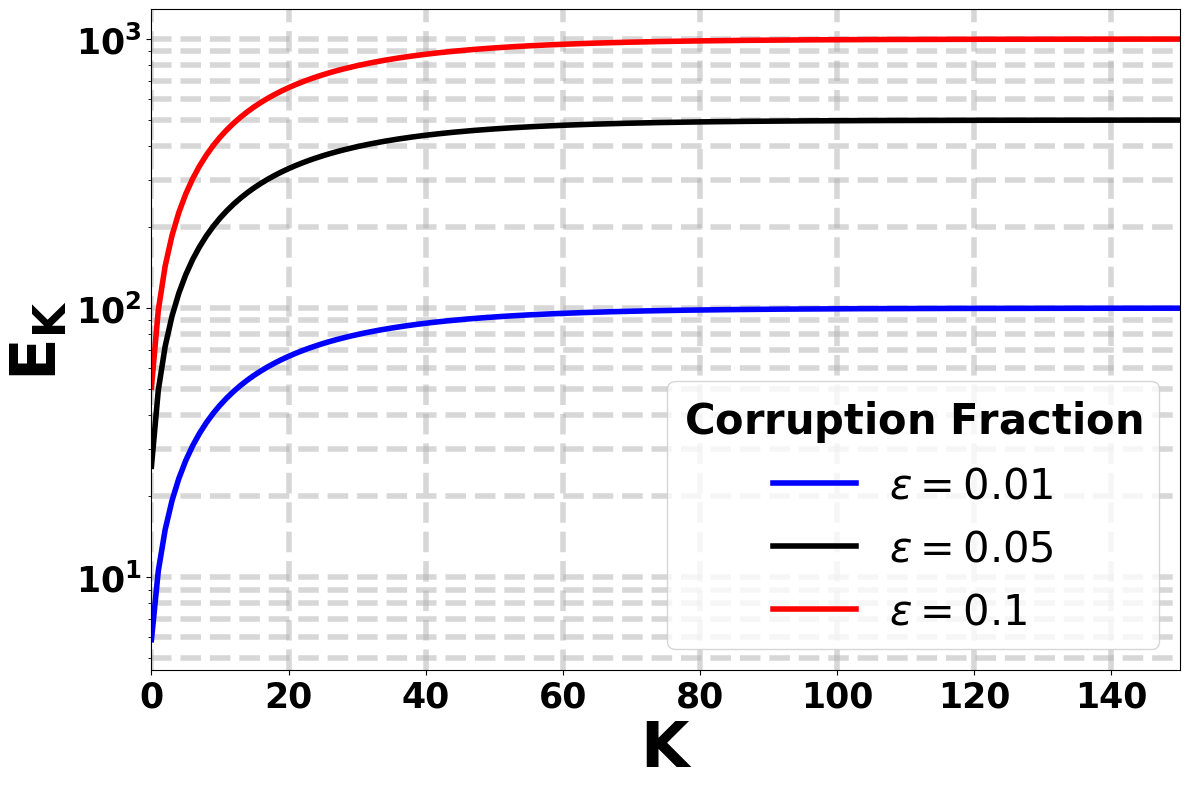

Saved: combined_traces.npy and combined_plot.png


In [56]:
# ---------- plot ----------
x = np.arange(max_len)
plt.figure(figsize=(12, 8))

# Define the colors you want
colors = ["blue", "black", "red"]

for i, y in enumerate(combined):
    label = all_labels[i] if i < len(all_labels) else f"curve {i+1}"
    color = colors[i % len(colors)]  # cycle through blue, black, red

    # semilogy if positive
    if np.all(y > 0):
        plt.semilogy(x, y, linewidth=4, label=label, color=color)
    else:
        plt.plot(x, y, linewidth=4, label=label, color=color)

plt.xlim([0, 150])
plt.xlabel(r'$\mathbf{K}$', fontsize=45, fontweight='bold')
plt.ylabel(r'$\mathbf{E_K}$', fontsize=45, fontweight='bold')
plt.legend(title=r'$\mathbf{Corruption\ Fraction\ }$', fontsize=30, title_fontsize=30)
plt.xticks(fontsize=25, fontweight='bold')
plt.yticks(fontsize=25, fontweight='bold')
plt.grid(True, which="both", linestyle="--", alpha=0.5, linewidth=4)
plt.tight_layout()
plt.savefig("combined_plot.png", dpi=1200)
plt.show()

print("Saved: combined_traces.npy and combined_plot.png")
